In [1]:
import numpy as np
import h5py
import scipy.signal
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2025-09-14 10:59:01.868191: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-14 10:59:01.868502: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-14 10:59:01.917328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-14 10:59:02.949443: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [ ]:
class Hdf5DataGenerator:

    def __call__(self, filename, batchsize):
        
        # When using with tensorflow datasets, string args are passed as bytes.
        # Convert them back
        if isinstance(filename, bytes):
            filename = filename.decode()

        with h5py.File(filename, "r") as fin:

            waveforms = fin.get('waveforms')
            event_types = fin.get('type')
            p_start = fin.get('p_start')
            s_start = fin.get('s_start')

            waveform_length = waveforms[0].shape[0]
            istart = 0
            istop = batchsize
            exhausted = False

            pick_width = 100
            half_pick_width = pick_width // 2
            pick = scipy.signal.windows.gaussian(pick_width, 12)


            assert False, 'NORMALIZE

            while not exhausted:

                data = waveforms[istart:istop]
                targets = []

                # Create the target class waveforms 
                for i in range(batchsize):

                    p_true = np.zeros(shape=(waveform_length))
                    s_true = np.zeros(shape=(waveform_length))
                    n_true = np.ones(shape=(waveform_length))
    
                    # Insert pick 
                    p_pos = p_start[i]
                    p_true[p_pos - half_pick_width : p_pos + half_pick_width] = pick
    
                    s_pos = s_start[i]
                    s_true[s_pos - half_pick_width : s_pos + half_pick_width] = pick
    
                    n_true -= p_true
                    n_true -= s_true

                    targets.append(
                        np.dstack([p_true, s_true, n_true])
                    )

                yield (data, np.vstack(targets))

                istart += batchsize
                istop += batchsize

                if istop > len(waveforms):
                    exhausted = True

                

            

        

In [ ]:
gen = Hdf5DataGenerator()


for batch in gen('selected_events.h5', 1):

    batch_data = batch[0]
    batch_targets = batch[1]
    
    print('batch_data.shape:', batch_data.shape)
    print('batch_targets.shape:', batch_targets.shape)

    for i in range(batch_data.shape[0]):

        data = batch_data[i]
        targets = batch_targets[i]
        
        _, ax = plt.subplots(4, 1, sharex=True)
        xvals = np.arange(data.shape[0])
    
        ax[0].plot(xvals, data[:, 2])
        ax[1].plot(xvals, targets[:, 0])
        ax[2].plot(xvals, targets[:, 1])
        ax[3].plot(xvals, targets[:, 2])

    
        break
    break

## Build a DETECTION model

In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=(6000, 1)),
        
        keras.layers.Conv1D(filters=64, kernel_size=3),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        
        keras.layers.Conv1D(filters=64, kernel_size=3),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        
        keras.layers.Conv1D(filters=64, kernel_size=3),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        
        #keras.layers.Flatten(),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(1, activation='softmax')
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 5998, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5998, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 5998, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 5996, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5996, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 5996, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5994, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5994, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 5994, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,793 (100.75 KB)

 Trainable params: 25,409 (99.25 KB)

 Non-trainable params: 384 (1.50 KB)

Compile

In [10]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam", 
    metrics=["accuracy"]
)

Load datasets

In [ ]:
# For phase picking
"""
train_dataset = tf.data.Dataset.from_generator(
    Hdf5DataGenerator(),
    output_signature=(
        tf.TensorSpec(shape=(None, 6000, 1), dtype=tf.float32, name='data'),
        tf.TensorSpec(shape=(None, 6000, 1), dtype=tf.float32, name='data')
    ), 
    args=(filename_train, batch_size)
)
"""

In [2]:
with h5py.File('events_Zonly_TRAIN.h5') as train_file:
    waveforms = train_file.get('waveforms')[:]
    event_types = train_file.get('type')[:]

event_types = np.expand_dims(event_types, axis=-1)

print('waveforms.shape:', waveforms.shape)
print('event_types.shape:', event_types.shape)

waveforms.shape: (100000, 6000, 1)
event_types.shape: (100000, 1)


In [3]:
# Normalise events to the same max amplitude 
max_vals = np.max(np.abs(waveforms), axis=1, keepdims=True)
waveforms /= (max_vals + 1e-8)

print('waveforms.shape:', waveforms.shape)

waveforms.shape: (100000, 6000, 1)


Text(0.5, 1.0, 'type: [0]')

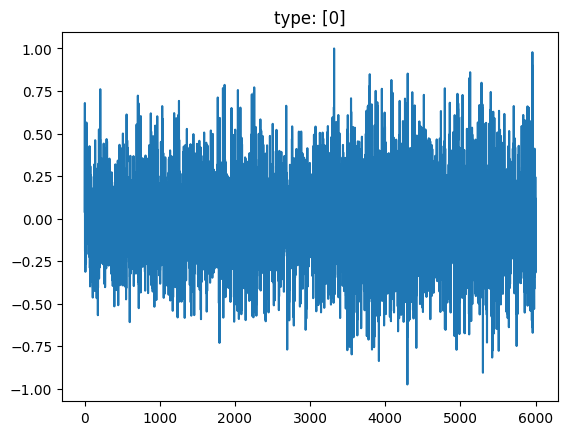

In [4]:
index = 0
plt.plot(np.arange(waveforms.shape[1]), waveforms[index,:,0])
plt.title(f'type: {event_types[index]}')

In [11]:
model.fit(
    waveforms,
    event_types,
    batch_size=128,
    epochs=1,
    validation_split=0.1,
    verbose=1
)

/home/steffen/projects/norsar-ml-workshop/uvenv/lib/python3.11/site-packages/keras/src/ops/nn.py:938: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/steffen/projects/norsar-ml-workshop/uvenv/lib/python3.11/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


  8/704 ━━━━━━━━━━━━━━━━━━━━ 15:22 1s/step - accuracy: 0.4980 - loss: 0.0000e+00

KeyboardInterrupt: 

In [8]:
print('Preds:')
print(model.predict(waveforms[:10]))
print('True:')
print(event_types[:10])

Preds:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
[[0.48134258]
 [0.4790909 ]
 [0.4789837 ]
 [0.48142722]
 [0.4815328 ]
 [0.47911614]
 [0.4805278 ]
 [0.47914526]
 [0.47992194]
 [0.47964653]]
True:
[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]]
